# **Signa_Lab ITESO: Análisis semántico, selección por frecuencia y selección aleatoria por tema**

## **Proyecto:** *Selección de Preguntas de Redes Sociales para 1er Debate Presidencial INE 2024 (Formato A)*

## **Tema:** Salud

Cuaderno de código para realizar el análisis semántico de preguntas,la selección por frecuencia y la selección por aleatoriedad dentro de la muestra estratificada de cada tema.

In [1]:
# Indicar tema de la muestra de datos a importar
tema_muestra = "Salud"
nombreArchivo = f"20240325_1759_PreguntasDebateINE_MuestraEstratificada_{tema_muestra}"


## **1. Descargar e importar librerías, dependencias y archivo de datos con *embeddings* procesados**


**Instalar librerías:**

In [ ]:
# Instalar librerías de Python necesarias

!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install plotly
!pip install umap-learn
!pip install sentence_transformers

!pip install matplotlib
!pip install yellowbrick

**Importar librerías:**

In [ ]:
# Importar librerías de Python necesarias

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import plotly.express as px
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE
import operator
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder, TrigramCollocationFinder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer, util

from sklearn import datasets
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer




nltk.download('punkt')
nltk.download('stopwords')

**Importar modelo de lenguaje para búsqueda semántica:**

\* Relaciones calculadas para la visualización y la búsqueda semántica con *embeddings* (vectores) generados el modelo de lenguaje de software libre [intfloat/multilingual-e5-large-instruct](https://huggingface.co/intfloat/multilingual-e5-large-instruct) (Wang et al, 2024), con la librería de aprendizaje profundo [sentence-transformers](https://www.sbert.net/) (Reimers & Gurevych, 2019).

In [ ]:
# importar modelo de lenguaje para búsqueda semántica
modelo = "./modelos/multilingual-e5-large-instruct"
# cargar modelo para embeddings
embedder = SentenceTransformer(modelo)

**Indicar ruta y cargar archivo de datos (CSV o JSON):**


In [5]:
# Ruta local:
ruta = "./data/20240325_1759_PreguntasDebateINE_MuestraEstratificada_SaludEmbeddings.csv"

fileType = "csv" # o json
embeddingsColumna = "Embedding"

if fileType == "csv":
  df = pd.read_csv(ruta)
else:
  df = pd.read_json(ruta)

# Verificar si la columna de embeddings son strings
if df[embeddingsColumna].apply(lambda x: isinstance(x, str)).all():
  df[embeddingsColumna] = df[embeddingsColumna].apply(lambda x: [float(i) for i in x.strip('[]').split(', ')])

**Revisar datos importados:**

In [ ]:
# Previsualizar tabla de datos importados
df.head()

In [7]:
# Verificar número de filas y columnas en datos importados
df.shape

(353, 14)

## **2. Reducción de dimensiones con distintas técnicas (UMAP, PCA, TSNE)**

Definir función para reducir dimensionalidades con: **UMAP**

In [8]:
# Definir función para UMAP
def genUMAP(df, columnaEmbeddings, nDims):
    dfW = df
    umap_model = umap.UMAP(n_components=nDims)
    X_umap = umap_model.fit_transform(dfW[columnaEmbeddings].tolist())
    dfW["embeddingsReducidos"] = X_umap.tolist()
    return dfW

Definir función para reducir dimensionalidades con: **PCA**

In [9]:
# Definir función para PCA
def genPCA(df, columnaEmbeddings, nDims):
    dfW = df
    pca = PCA(n_components=nDims)
    X_pca = pca.fit_transform(dfW[columnaEmbeddings].tolist())
    dfW["embeddingsReducidos"] = list(X_pca)
    return dfW

Definir función para reducir dimensionalidades con: **TSNE**

In [10]:
# Definir función para TSNE
def genTSNE(df, columnaEmbeddings, nDims):
    dfW = df
    tsne = TSNE(n_components=nDims, random_state=42)
    X_tsne = tsne.fit_transform(dfW[columnaEmbeddings].tolist())
    dfW["embeddingsReducidos"] = list(X_tsne)
    return dfW

**Definir función para elegir método para reducir dimensiones:**

In [11]:
def reduceDim(df, columnaEmbeddings, nDims, method):
    if method.lower() == 'umap':
        return genUMAP(df, columnaEmbeddings, nDims)
    elif method.lower() == 'pca':
        return genPCA(df, columnaEmbeddings, nDims)
    elif method.lower() == 'tsne':
        return genTSNE(df, columnaEmbeddings, nDims)

**Elegir método a utilizar, número de dimensiones (2D o 3D) y ejecutar reducción de dimensionalidades sobre *embeddings* cargados:**

In [12]:
#Indicar nombre de columna con embeddings completos (vector dado por las dimensiones del modelo de lenguaje)
columnaConEmbeddings = "Embedding"

#Indicar si se busca reducir a 2 o 3 dimensiones para visualizador 2D o 3D
numDimensiones = 3

# Elegir método para reducción de dimensionalidades: "umap", "tsne", "pca"
metodo = "umap"

# Ejecutar reducción de dimensionalidades
datasetConDimensionesReducidas = reduceDim(df, columnaConEmbeddings, numDimensiones, metodo)

In [ ]:
datasetConDimensionesReducidas.head()

## **3. Clusterización y visualización de *embeddings***

Definir función para **Método del Codo** para calcular número ideal de clústers para los datos cargados:

In [14]:
def elbowMethod(df, columnWiEmbeddings, rangoPosibleDeCluster, byRegion=False):
    # Convierte la columna de embeddings del DataFrame a un array de numpy para su procesamiento
    embeddings = np.array(df[columnWiEmbeddings].tolist())
    # Calcula la inercia para diferentes valores de k (número de clústeres)
    # Inicializa una lista vacía para almacenar los valores de inercia calculados para cada número de clústeres
    inertia_values = []
    # Define un rango de valores de k (número de clústeres) para probar, basándose en el rango proporcionado como argumento
    possible_k_values = range(rangoPosibleDeCluster[0], rangoPosibleDeCluster[1]+1)  # Prueba k desde n1 hasta n2 clústeres

    # Itera sobre el rango de posibles valores de k
    for index, k in enumerate(possible_k_values):
        # Inicializa el algoritmo KMeans con el número actual de clústeres (k) y una semilla aleatoria fija
        kmeans = KMeans(n_clusters=k, random_state=0)

        # Entrena el modelo KMeans con los embeddings
        kmeans.fit(embeddings)

        # Añade la inercia del modelo (la suma de las distancias cuadradas de las muestras a su centro de clúster más cercano) a la lista de valores de inercia
        inertia_values.append(kmeans.inertia_)

    # Prepara los resultados para ser graficados, conteniendo los valores de k y las inercias correspondientes
    resToPlot = [possible_k_values, inertia_values]

    # Grafica el método del codo utilizando matplotlib, donde el eje X representa el número de clústeres y el eje Y la inercia
    plt.plot(resToPlot[0], resToPlot[1], marker='o')
    plt.xlabel('Número de Clústers (k)')
    plt.ylabel('Inercia')
    plt.title('Método del Codo para Determinar Número de Clústers (k)')
    plt.show()

**Ejecutar método del codo** para identificar número deseable de clústers:

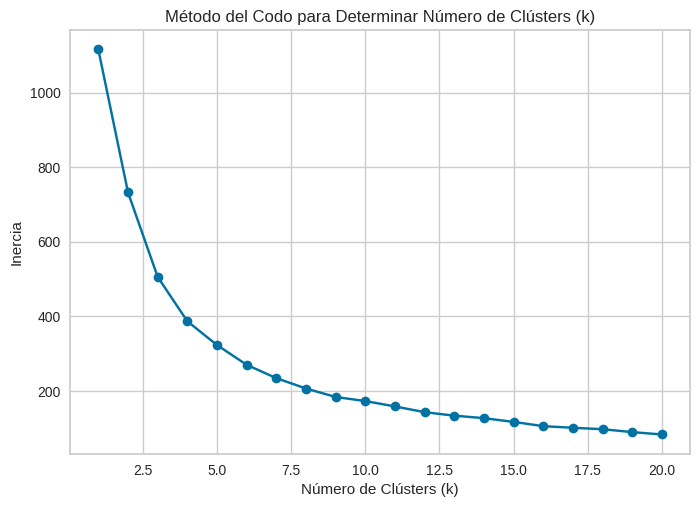

In [15]:
# Indicar nombre de columna con embeddings reducidos
columnaConEmbeddings = "embeddingsReducidos"
# Calcular número ideal en un rango de 1 a 20 clústers
rangoDeClusters = [1,20]
elbowMethod(datasetConDimensionesReducidas, columnaConEmbeddings, rangoDeClusters)

Definir función para **Método de Silueta** para calcular número ideal de clústers para los datos cargados:

In [16]:
def silhouetteMethod(df, columnWithEmbeddings, rangeOfClusters):
    # Convierte la columna de embeddings del DataFrame a un array de numpy para su procesamiento
    embeddings = np.array(df[columnWithEmbeddings].tolist())

    # Establece el número de subplots basado en el rango de clústeres a analizar
    n_clusters = range(rangeOfClusters[0], rangeOfClusters[1] + 1)
    n_rows = len(n_clusters) // 2 + len(n_clusters) % 2
    fig, ax = plt.subplots(n_rows, 2, figsize=(16, 32))
    plt.subplots_adjust(hspace=0.5)

    # Itera sobre el rango especificado de número de clústeres
    for i, k in enumerate(n_clusters):
        # Crea una instancia de KMeans para el número actual de clústeres
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=42)

        # Calcula la fila y columna para el subplot actual
        q, mod = divmod(i, 2)

        # Crea una instancia de SilhouetteVisualizer para visualizar el coeficiente de silueta
        visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q][mod])

        # Ajusta el visualizador con los embeddings
        visualizer.fit(embeddings)

        # Establece el título del subplot
        ax[q][mod].set_title(f'Clusters: {k}')

    # Ajusta la disposición de los subplots para evitar solapamientos
    plt.tight_layout()
    plt.show()

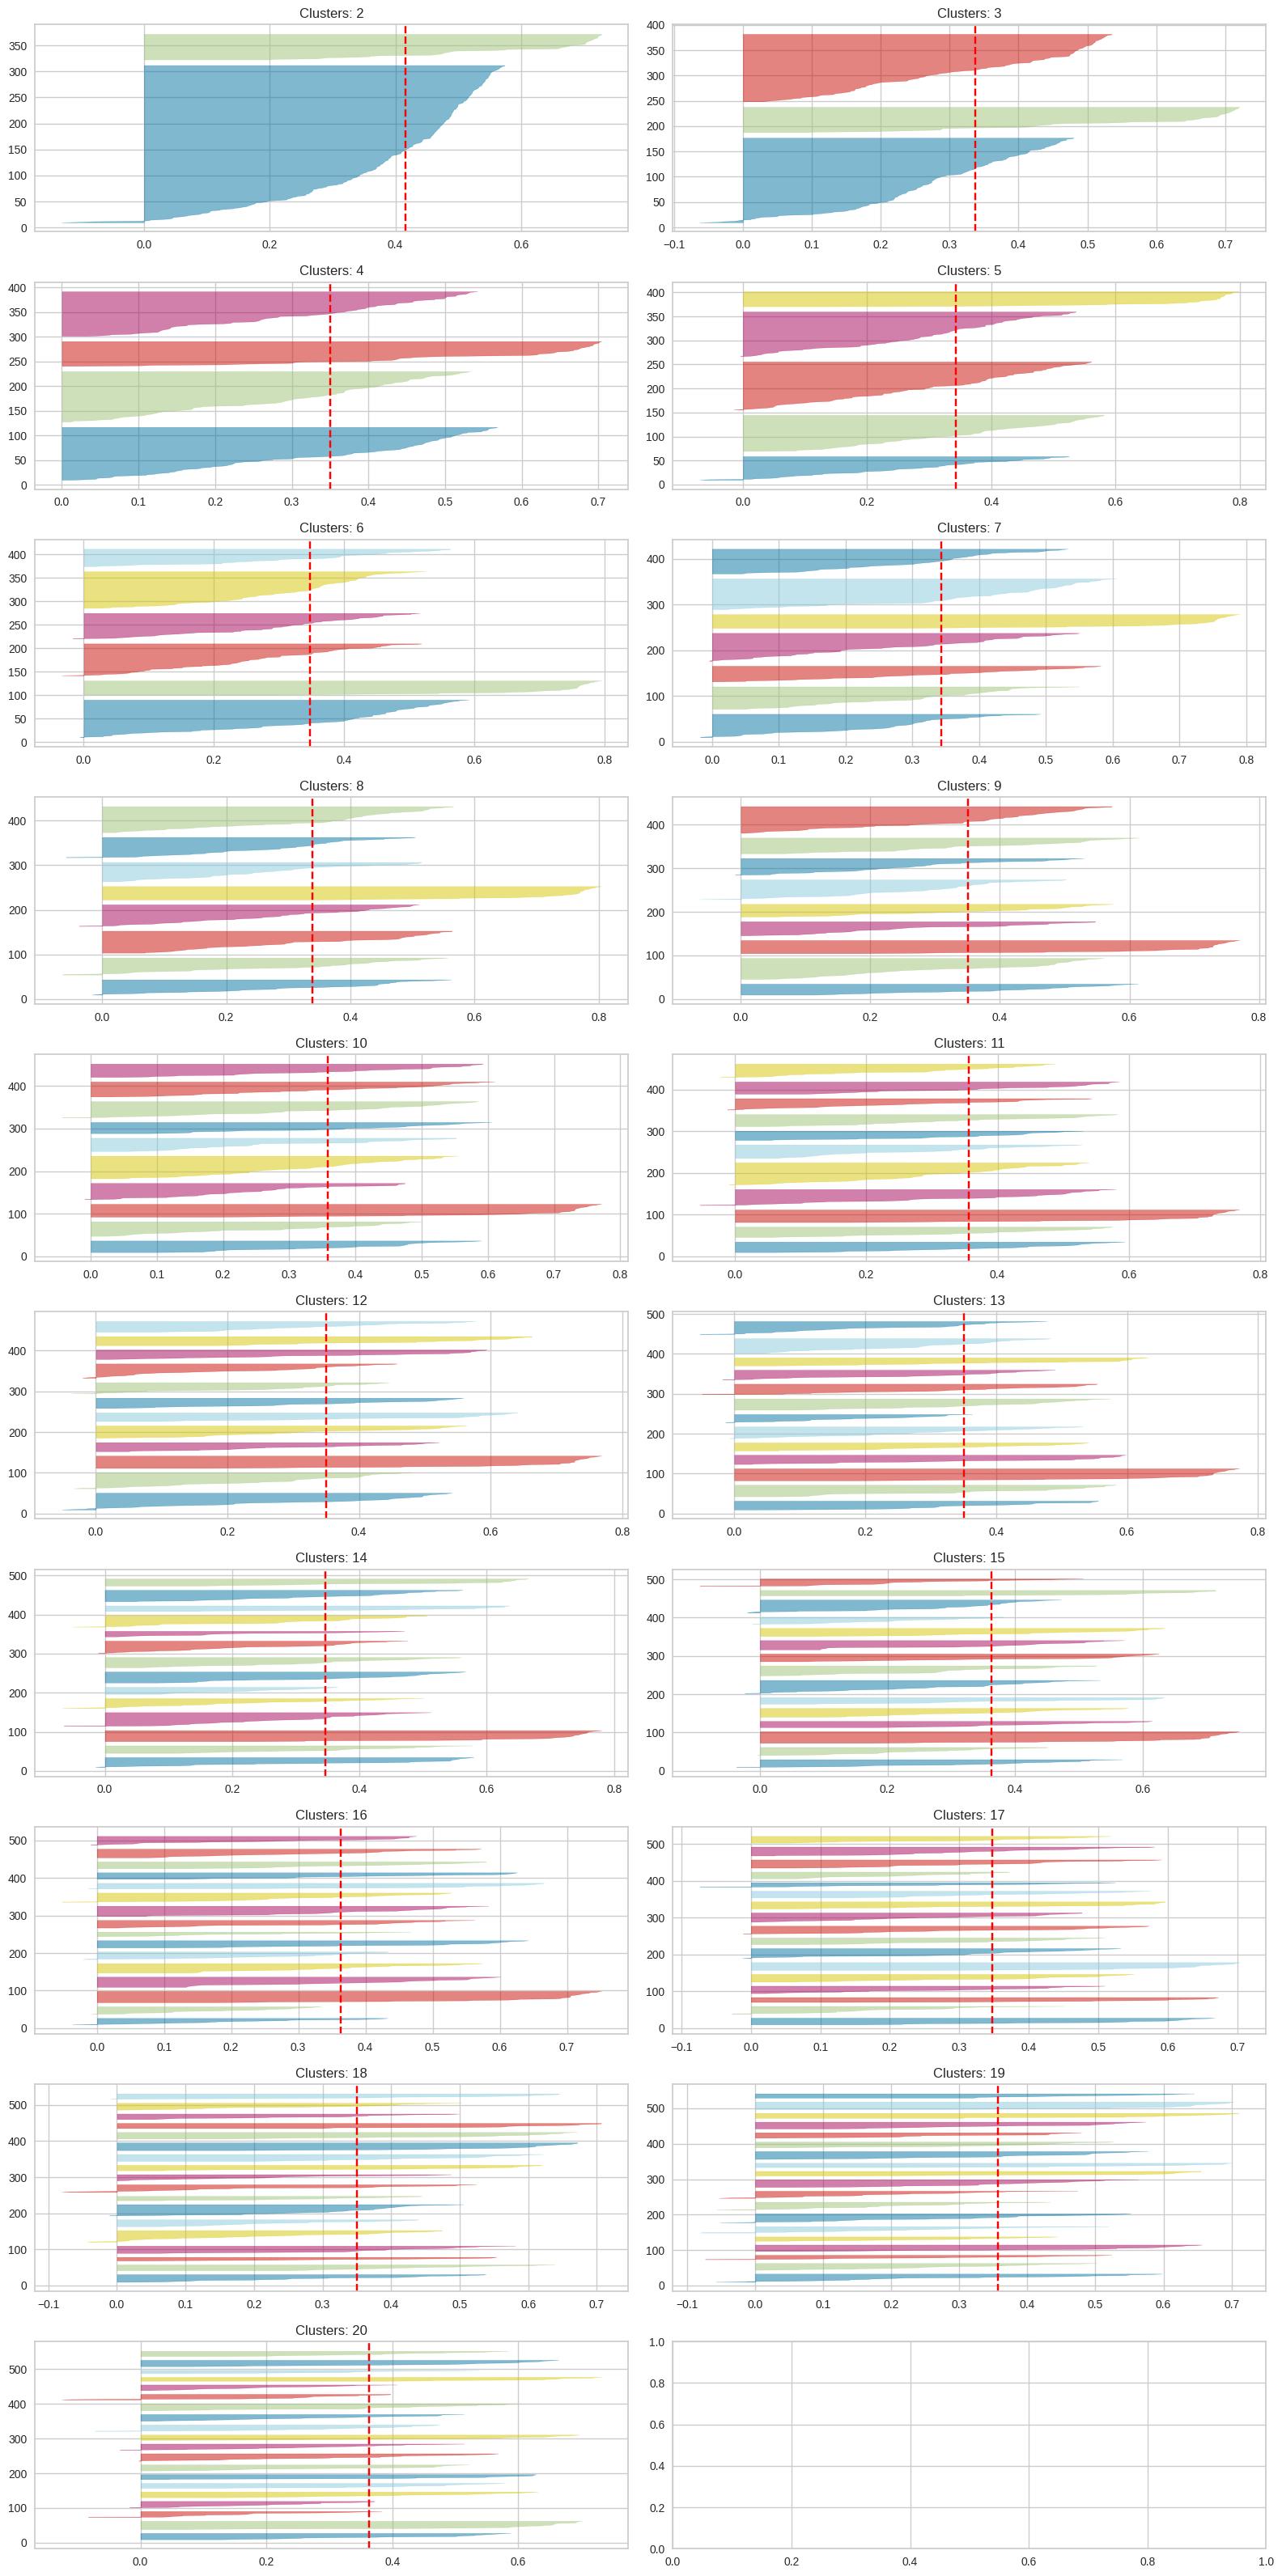

In [17]:
# Ejecutar función de método de silueta
silhouetteMethod(df, 'embeddingsReducidos', (2, 20))

Definir función de clusterizarización utilizando método **K-Means:**

In [18]:
# Definir función de clusterización con K-means
def clusterKmeans(df, optimal_k_value, columnaEmbeddings, byRegion=False, cluster_col_name=None):
    embeddings = df[columnaEmbeddings].tolist()
    dfW = df.copy() # Crear copia de trabajo de DataFrame

    if cluster_col_name is None:
      cluster_col_name = "cluster"

    try:
        if byRegion: # Clusterización por región (opcional, no utilizado en metodología final)
            # Inicializar nueva columna para alojar etiquetas de clústeres
            dfW[cluster_col_name] = None

            # Iterar sobre cada región (opcional)
            for region, df_region in dfW.groupby('region'):
                # Aplicar clusterización de K-means en cada región (opcional)
                kmeans = KMeans(n_clusters=optimal_k_value, random_state=0)
                cluster_labels = kmeans.fit_predict(df_region[columnaEmbeddings].tolist())

                # Añadir prefijo de clúster por región (opcional)
                prefixed_cluster_labels = [f"{region}_{label}" for label in cluster_labels]

                # Asignar etiquetas de clúster por región a DataFrame
                dfW.loc[dfW['region'] == region, cluster_col_name] = prefixed_cluster_labels
        else:
            # Aplicar clusterización por K-means a todo el conjunto de datos importado (versión implementada en metodología final)
            kmeans = KMeans(n_clusters=optimal_k_value, random_state=0)
            cluster_labels = kmeans.fit_predict(embeddings)
            dfW[cluster_col_name] = cluster_labels

        return dfW
    except Exception as e:
        print(f"Error al generar clusters: {e}")
        return pd.DataFrame({0: ["Error al generar clusters"]})

**Ejecutar clusterización** con número deseado de clúster con método *k-means:*

In [19]:
# Indicar nombre de columna con embeddings reducidos
columnaConEmbeddings = "embeddingsReducidos"
# Indicar número de clústers a segmentar
numeroDeClusters = 7
dfClusterizado = clusterKmeans(datasetConDimensionesReducidas, numeroDeClusters, columnaConEmbeddings, byRegion=False)

In [ ]:
# Previsualizar tabla de preguntas con sus respectivos clústers asignados
dfClusterizado

Definir función para **visualizar relaciones semánticas y clústeres en 3D:**

In [21]:
def visualize3D(df, columnaEmbeddingsReducidas, columnaTexto, byRegion=False, columnaCluster=None):
  if columnaCluster is None:
    columnaCluster = "cluster"
  embeddingWithSelectedDimensions = df[columnaEmbeddingsReducidas].tolist()
  dfToPlot = {
        "X": [x[0] for x in embeddingWithSelectedDimensions],
        "Y": [y[1] for y in embeddingWithSelectedDimensions],
        "Z": [z[2] for z in embeddingWithSelectedDimensions],
        "cluster": df[columnaCluster].tolist(),
        "text": df[columnaTexto]
  }

  fig = px.scatter_3d(dfToPlot, x='X', y='Y', z='Z', color='cluster', hover_data=["text"],
                         labels={'X': 'Dimensión 1', 'Y': 'Dimensión 2', 'Z': 'Dimensión 3'},
                         title=f'Visualización de clústers semánticos de {tema_muestra}',
                         color_discrete_sequence=px.colors.sequential.Viridis)
  fig.show()

**Ejecutar visualización de clústers 3D:**

In [ ]:
# Indicar nombre de columna con embeddings reducidos
columnaConEmbeddings = "embeddingsReducidos"
# Indicar columna de texto para etiquetas
columnaTextoClusterizado = "clean_text"
visualize3D(dfClusterizado, columnaConEmbeddings, columnaTextoClusterizado, columnaCluster="cluster")

**Exportar archivos de datos (formato CSV y JSON) con clústers calculados:**

In [23]:
# Exportar en json
dfClusterizado.to_json(f"{nombreArchivo}Clusters.json")

In [24]:
# Exportar en csv
dfClusterizado.to_csv(f"{nombreArchivo}Clusters.csv")

## **4. Análisis semántico, exploración y selección de preguntas frecuentes**

In [25]:
# Reimportar archivo CSV con clústers calculados para el tema
ruta = f"./data/{nombreArchivo}Clusters.json"

dfClusterizado = pd.read_json(ruta)

In [ ]:
dfClusterizado

### **Definir funciones necesarias para el análisis semántico:**


Definir función para identificar **términos más frecuentes por método TF-IDF con toda la muestra:**

In [27]:
# Definir función para calcular términos frecuentes por método TF-IDF para muestra completa
def generateTfidfForCompleteSample(df, columnaPreguntas, n=20):
  vectorizador_tfidf = TfidfVectorizer()
  tfidf_matriz = vectorizador_tfidf.fit_transform(df[columnaPreguntas])
  terminos = vectorizador_tfidf.get_feature_names_out()
  tfidf_promedio = tfidf_matriz.mean(axis=0).tolist()[0]
  tfidf_terminos = [(termino, tfidf) for termino, tfidf in zip(terminos, tfidf_promedio)]
  tfidf_terminos_importantes = sorted(tfidf_terminos, key=lambda x: x[1], reverse=True)[:n]
  return tfidf_terminos_importantes


Definir función para identificar **términos más frecuentes por método TF-IDF por clúster**

In [28]:
# Definir función para calcular términos frecuentes por método TF-IDF por clúster
def funcion_tfidf_cluster(dfClusterizado, n=20, agrupar_por_region=False, n_cluster=None):
    # Inicializar el vectorizador TF-IDF
    vectorizador_tfidf = TfidfVectorizer()

    # Calcular las características TF-IDF por cluster
    tfidf_por_cluster = {}

    if agrupar_por_region:
        for region, df_region in dfClusterizado.groupby('region'):
            clusters = df_region['cluster'].unique()
            for cluster in clusters:
                if n_cluster is not None and cluster != n_cluster:
                    continue
                preguntas_cluster = df_region[df_region['cluster'] == cluster]['sem_text'].dropna()
                tfidf_matriz = vectorizador_tfidf.fit_transform(preguntas_cluster)
                terminos = vectorizador_tfidf.get_feature_names_out()
                tfidf_promedio = tfidf_matriz.mean(axis=0).tolist()[0]
                tfidf_terminos = [(termino, tfidf) for termino, tfidf in zip(terminos, tfidf_promedio)]
                tfidf_terminos_importantes = sorted(tfidf_terminos, key=lambda x: x[1], reverse=True)[:n]
                if region not in tfidf_por_cluster:
                    tfidf_por_cluster[region] = {}
                tfidf_por_cluster[region][cluster] = tfidf_terminos_importantes
    else:
        clusters = dfClusterizado['cluster'].unique()
        for cluster in clusters:
            if n_cluster is not None and cluster != n_cluster:
                continue
            preguntas_cluster = dfClusterizado[dfClusterizado['cluster'] == cluster]['sem_text'].dropna()
            tfidf_matriz = vectorizador_tfidf.fit_transform(preguntas_cluster)
            terminos = vectorizador_tfidf.get_feature_names_out()
            tfidf_promedio = tfidf_matriz.mean(axis=0).tolist()[0]
            tfidf_terminos = [(termino, tfidf) for termino, tfidf in zip(terminos, tfidf_promedio)]
            tfidf_terminos_importantes = sorted(tfidf_terminos, key=lambda x: x[1], reverse=True)[:n]
            tfidf_por_cluster[cluster] = tfidf_terminos_importantes

    # Devolver los términos TF-IDF más prominentes por cluster y región si se agrupó por región, de lo contrario, solo por cluster
    return tfidf_por_cluster

Definir función para identificar **relaciones entre pares de palabras (bigramas) más frecuentes:**

In [29]:
# Definir función para calcular bigramas indicando un clúster específico u omitirlo para aplicarse con la muestra completa
def calculate_bigrams(df, nCluster=None):
    # Inicializar una lista para alojar todas las palabras en columna 'pregunta'
    all_words = []

    if nCluster is not None:
      dfW = df[df["cluster"] == nCluster]
      df = pd.DataFrame(dfW["sem_text"])
    else:
      df = pd.DataFrame(df["sem_text"])

    # Correr filtro por stopwords
    stop_words = set(stopwords.words('spanish'))

    for pregunta in df['sem_text']:
        # Tokenizar textos de columna pregunta text por palabra
        tokens = word_tokenize(pregunta, language='spanish')
        # Filtrar stopwords de tokens
        filtered_words = [word for word in tokens if word.lower() not in stop_words]
        all_words.extend(filtered_words)

    # Configurar identificador de bigramas
    bigram_measures = BigramAssocMeasures()
    bigram_finder = BigramCollocationFinder.from_words(all_words)

    # Calcular peso de bigramas utilizando frecuencia
    bigrams = bigram_finder.score_ngrams(bigram_measures.raw_freq)

    # Convertir bigramas calculados y su frecuencia en dataFrame
    bigrams_df = pd.DataFrame([(src, tgt, weight) for ((src, tgt), weight) in bigrams],
                              columns=['source', 'target', 'weight'])

    bigrams_df = bigrams_df.sort_values(by='weight', ascending=False)  # Ordenar bigramas por frecuencia

    return bigrams_df  # Regresar dataFrame con lista bigramas ordenados

Definir función para identificar **relaciones entre secuencias de 3 palabras (trigramas) más frecuentes:**

In [30]:
# Definir función para calcular trigramas indicando un clúster específico u omitirlo para aplicarse con la muestra completa
def calculate_trigrams(df, nCluster=None):
    stop_words = set(stopwords.words('spanish'))
    all_words = []

    if nCluster is not None:
      dfW = df[df["cluster"] == nCluster]
      df = pd.DataFrame(dfW["sem_text"])
    else:
      df = pd.DataFrame(df["sem_text"])

    for pregunta in df['sem_text']:  # Adjust this to match your column name
        tokens = word_tokenize(pregunta)
        filtered_words = [word for word in tokens if word not in stop_words]
        all_words.extend(filtered_words)

    bigram_measures = BigramAssocMeasures()
    trigram_finder = TrigramCollocationFinder.from_words(all_words)

    trigrams = trigram_finder.score_ngrams(bigram_measures.raw_freq)

    trigrams_df = pd.DataFrame([(src, mid, tgt, weight) for ((src, mid, tgt), weight) in trigrams],
                               columns=['source', 'middle', 'target', 'weight'])

    trigrams_df = trigrams_df.sort_values(by='weight', ascending=False)  # Ordenar bigramas por frecuencia

    return trigrams_df   # Regresar dataFrame con lista bigramas ordenados


### **Análisis Semántico de Muestra Completa. Frecuencia de términos y relaciones entre palabras en muestra completa del tema:**


Ejecutar función para identificar **términos más frecuentes por método TF-IDF con toda la muestra:**

In [31]:
# Indicar número de términos más frecuentes a enlistar por método TF-IDF
nPalabrasFrecuentesDatasetCompleto = 20
tfidfDatasetCompleto = generateTfidfForCompleteSample(dfClusterizado, "sem_text", nPalabrasFrecuentesDatasetCompleto)

In [32]:
# Enlistar términos más frecuentes en muestra completa por método TF-IDF
tfidfDatasetCompleto

[('salud', 0.0604230064796448),
 ('sistema', 0.031115498765376955),
 ('atención', 0.025502033107839186),
 ('mejorar', 0.02468044427511685),
 ('medicamentos', 0.02308377867406505),
 ('hospitales', 0.020045465338550675),
 ('cómo', 0.019890591686370432),
 ('servicios', 0.01884425263920815),
 ('personas', 0.018605649282846925),
 ('méxico', 0.01836185064840452),
 ('que', 0.018147414781456355),
 ('seguro', 0.017277462214781648),
 ('calidad', 0.016610821651821678),
 ('país', 0.015928147902837513),
 ('imss', 0.015403170988890045),
 ('acceso', 0.01503119803748324),
 ('van', 0.014818523380139637),
 ('hacer', 0.014574691585961126),
 ('personal', 0.013641517604492828),
 ('estrategia', 0.013607664794674778)]

In [33]:
df_tfidfDatasetCompleto = pd.DataFrame(tfidfDatasetCompleto, columns=["términos","coeficientes"])

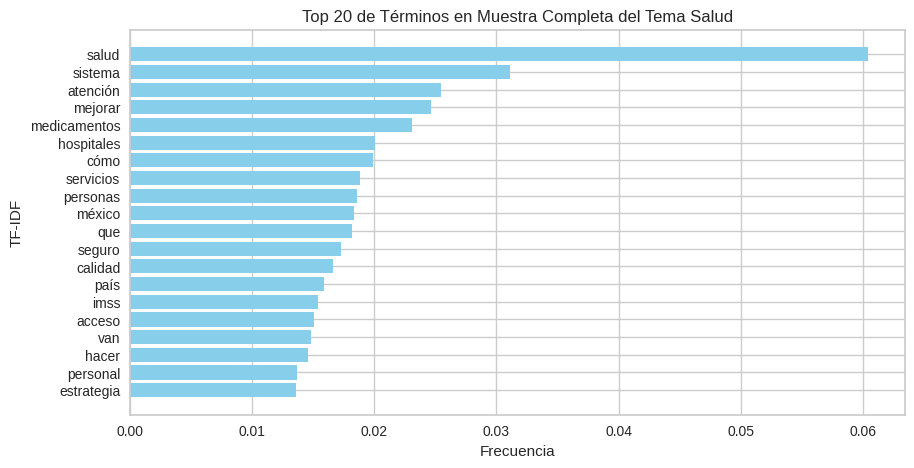

In [34]:
top_tfidf_muestra = df_tfidfDatasetCompleto.head(20)

# Crear un gráfico de barras horizontal
plt.figure(figsize=(10, 5))
plt.barh(top_tfidf_muestra['términos'], top_tfidf_muestra['coeficientes'], color='skyblue')
plt.xlabel('Frecuencia')
plt.ylabel('TF-IDF')
plt.title(f'Top 20 de Términos en Muestra Completa del Tema {tema_muestra}')
plt.gca().invert_yaxis()
plt.show()

Ejecutar función para identificar **relaciones entre pares de palabras (bigramas) más frecuentes en toda la muestra:**

In [35]:
# Ejecutar cálculo de bigramas
bigrama_muestra = calculate_bigrams(dfClusterizado)

In [36]:
bigrama_muestra

,source,target,weight
0,sistema,salud,0.010823
1,servicios,salud,0.004735
2,atención,médica,0.003157
3,sector,salud,0.002706
4,seguro,popular,0.002480
...,...,...,...
1476,desempleado,quede,0.000225
1477,desencadenado,disminución,0.000225
1478,desfavorable,planean,0.000225
1479,desfavorecidas,país,0.000225


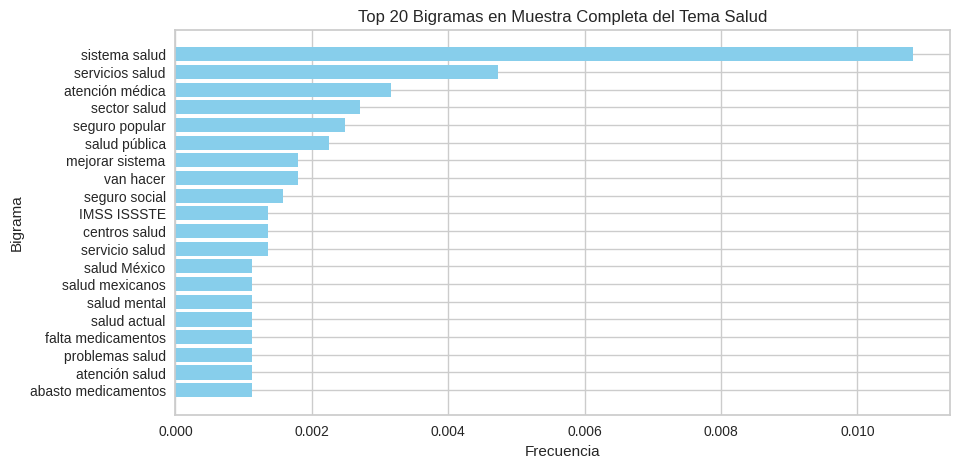

In [37]:
top_bigrams_muestra = bigrama_muestra.head(20)

# Crear un gráfico de barras horizontal
plt.figure(figsize=(10, 5))
plt.barh(top_bigrams_muestra['source'] + ' ' + top_bigrams_muestra['target'], top_bigrams_muestra['weight'], color='skyblue')
plt.xlabel('Frecuencia')
plt.ylabel('Bigrama')
plt.title(f'Top 20 Bigramas en Muestra Completa del Tema {tema_muestra}')
plt.gca().invert_yaxis()
plt.show()

Ejecutar función para identificar **relaciones entre secuencias de 3 palabras (trigramas) más frecuentes:**

In [38]:
# Ejecutar cálculo de trigramas
trigrama_muestra = calculate_trigrams(dfClusterizado)
trigrama_muestra

,source,middle,target,weight
0,mejorar,sistema,salud,0.001484
1,sistema,salud,actual,0.001060
2,CALIDAD,DE,VIDA,0.000636
3,acceso,atención,médica,0.000636
4,mejorar,acceso,calidad,0.000636
...,...,...,...,...
1581,cáncer,diabetes,problemas,0.000212
1580,cáncer,Se,proyectado,0.000212
1579,cáncer,Cómo,mejorarían,0.000212
1578,cáncer,Américas,aumente,0.000212


**Visualizar trigramas de toda la muestra**

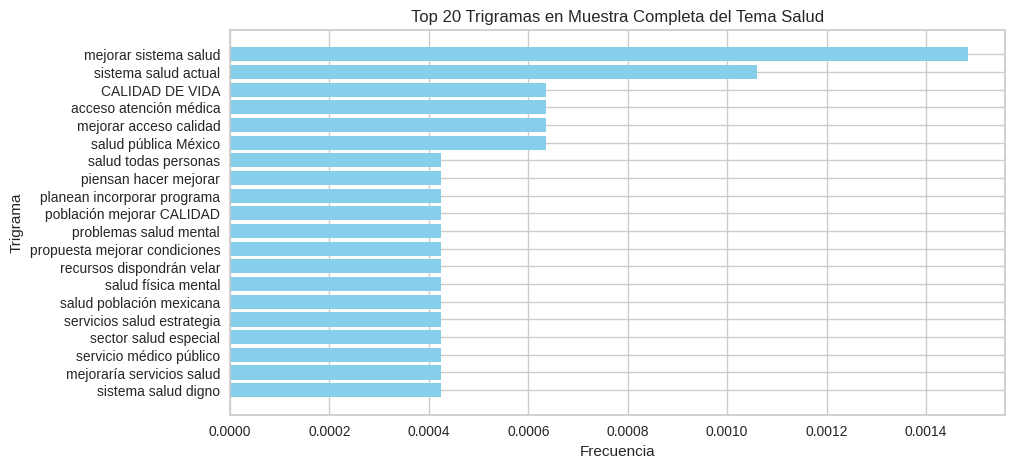

In [39]:
top_trigrams_muestra = trigrama_muestra.head(20)

# Crear un gráfico de barras horizontal
plt.figure(figsize=(10, 5))
plt.barh(top_trigrams_muestra['source'] + ' ' + top_trigrams_muestra['middle'] + ' ' + top_trigrams_muestra['target'], top_trigrams_muestra['weight'], color='skyblue')
plt.xlabel('Frecuencia')
plt.ylabel('Trigrama')
plt.title(f'Top 20 Trigramas en Muestra Completa del Tema {tema_muestra}')
plt.gca().invert_yaxis()
plt.show()

### **Análisis Semántico por Clústers. Frecuencia de términos y relaciones entre palabras por clúster:**


**Identificar clústers más grandes en la muestra del tema** (mayor frecuencia de preguntas por similitud semántica):

In [40]:
# Identificar y enlistar clusters con mayor cantidad de preguntas (más frecuentes) del tema
for cluster, freq in dfClusterizado['cluster'].value_counts(ascending=False).head(10).items():
  print(f"Cluster {cluster} - {freq} preguntas")

print()


Cluster 5 - 62 preguntas
Cluster 3 - 62 preguntas
Cluster 6 - 61 preguntas
Cluster 1 - 47 preguntas
Cluster 0 - 45 preguntas
Cluster 2 - 42 preguntas
Cluster 4 - 34 preguntas



In [41]:
# Asignar valores de referencia para 1er, 2ndo y 3er clúster
cluster_1 = 5
cluster_2 = 3
cluster_3 = 6

#### **Análisis semántico de 1er cluster** por cantidad de preguntas:

**Calcular términos más frecuentes por método TF-IDF para 1er clúster:**

In [42]:
# Indicar número de clúster y cantidad de términos a enlistar con mayor puntuación tras el análisis TF-IDF
cluster_tfid_1 = cluster_1
n_terminos = 20

# tfidf_por_cluster_region = funcion_tfidf(dfClusterizado, n=3, agrupar_por_region=True, n_cluster=cluster_tfid)
tfidf_por_cluster_1 = funcion_tfidf_cluster(dfClusterizado, n=n_terminos, agrupar_por_region=False, n_cluster=cluster_tfid_1)

In [43]:
# Enlistar términos con mayor frecuencia en clúster calculados por análisis TF-IDF
tfidf_por_cluster_1[5]

[('salud', 0.09965175396371125),
 ('sistema', 0.062191340373611376),
 ('atención', 0.051093165808037196),
 ('mejorar', 0.03445748806882512),
 ('personas', 0.03167690592298161),
 ('propuesta', 0.03156981361998893),
 ('propuestas', 0.03136964371009863),
 ('personal', 0.03067531933011715),
 ('médica', 0.02815538894117605),
 ('cómo', 0.02542868081910358),
 ('actual', 0.023890454015349612),
 ('piensan', 0.023638139391372152),
 ('hacer', 0.023621596486839886),
 ('que', 0.022948834281169644),
 ('mental', 0.022922676604339692),
 ('hospitales', 0.02275068654209777),
 ('van', 0.01885533220158438),
 ('dentro', 0.018674738783822344),
 ('mayores', 0.018411425643914212),
 ('servicio', 0.017900983573072803)]

In [44]:
# Enlistar términos con mayor frecuencia en clúster calculados por análisis TF-IDF
tfidf_por_cluster_1 = tfidf_por_cluster_1[cluster_1]
tfidf_por_cluster_1

[('salud', 0.09965175396371125),
 ('sistema', 0.062191340373611376),
 ('atención', 0.051093165808037196),
 ('mejorar', 0.03445748806882512),
 ('personas', 0.03167690592298161),
 ('propuesta', 0.03156981361998893),
 ('propuestas', 0.03136964371009863),
 ('personal', 0.03067531933011715),
 ('médica', 0.02815538894117605),
 ('cómo', 0.02542868081910358),
 ('actual', 0.023890454015349612),
 ('piensan', 0.023638139391372152),
 ('hacer', 0.023621596486839886),
 ('que', 0.022948834281169644),
 ('mental', 0.022922676604339692),
 ('hospitales', 0.02275068654209777),
 ('van', 0.01885533220158438),
 ('dentro', 0.018674738783822344),
 ('mayores', 0.018411425643914212),
 ('servicio', 0.017900983573072803)]

In [45]:
df_tfidf_cluster_1 = pd.DataFrame(tfidf_por_cluster_1, columns=["términos", "frecuencias"])

In [46]:
df_tfidf_cluster_1

,términos,frecuencias
0,salud,0.099652
1,sistema,0.062191
2,atención,0.051093
3,mejorar,0.034457
4,personas,0.031677
5,propuesta,0.031570
6,propuestas,0.031370
7,personal,0.030675
8,médica,0.028155
9,cómo,0.025429


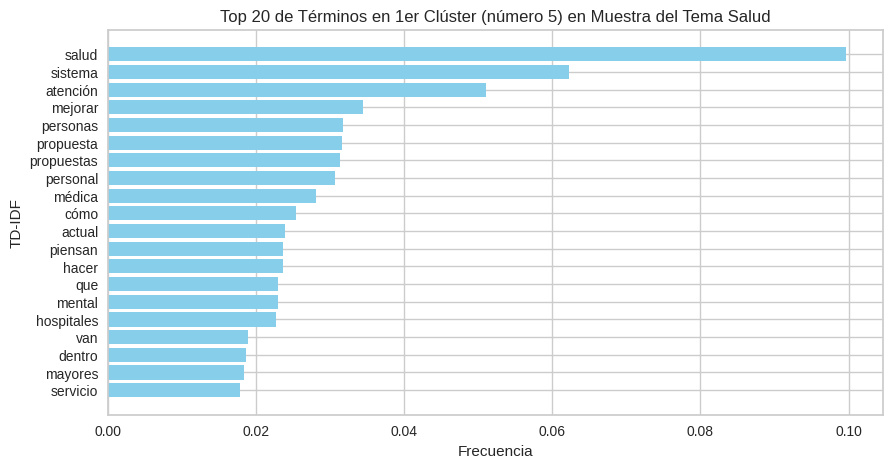

In [47]:
top_tfidf_cluster_1 = df_tfidf_cluster_1.head(20)

# Crear un gráfico de barras horizontal
plt.figure(figsize=(10, 5))
plt.barh(df_tfidf_cluster_1['términos'], df_tfidf_cluster_1['frecuencias'], color='skyblue')
plt.xlabel('Frecuencia')
plt.ylabel('TD-IDF')
plt.title(f'Top 20 de Términos en 1er Clúster (número {cluster_1}) en Muestra del Tema {tema_muestra}')
plt.gca().invert_yaxis()
plt.show()

**Calcular bigrama para 1er clúster:**

In [48]:
# Indicar número de clúster con mayor cantidad de preguntas
n_cluster_1 = cluster_1
bigrama_cluster_1 = calculate_bigrams(dfClusterizado, n_cluster_1)
bigrama_cluster_1

,source,target,weight
0,sistema,salud,0.031477
1,atención,médica,0.012107
2,salud,actual,0.007264
3,salud,pública,0.007264
10,personal,salud,0.004843
...,...,...,...
134,erradicar,negligencia,0.002421
133,enfermedades,crónicas,0.002421
132,ejercería,optimizar,0.002421
131,ejercer,sector,0.002421


**Visualizar bigrama de 1er cluster** con mayor cantidad de preguntas:

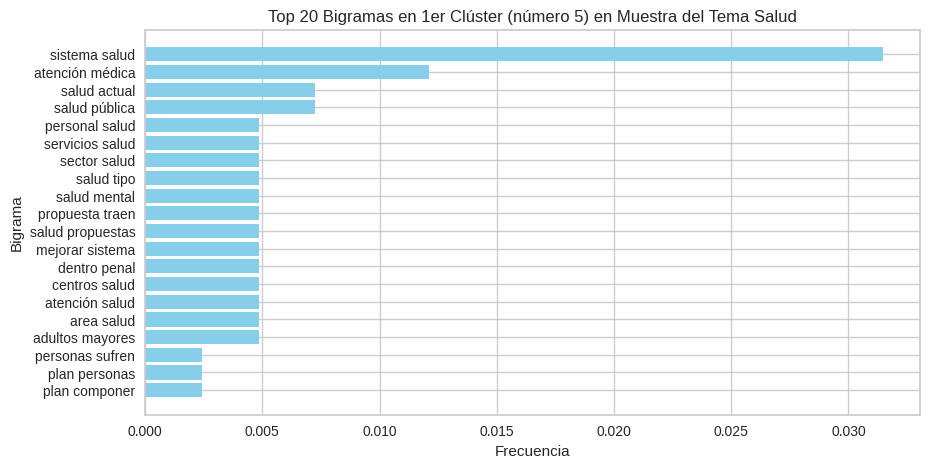

In [49]:
top_bigrams_cluster_1 = bigrama_cluster_1.head(20)

# Crear un gráfico de barras horizontal
plt.figure(figsize=(10, 5))
plt.barh(top_bigrams_cluster_1['source'] + ' ' + top_bigrams_cluster_1['target'], top_bigrams_cluster_1['weight'], color='skyblue')
plt.xlabel('Frecuencia')
plt.ylabel('Bigrama')
plt.title(f'Top 20 Bigramas en 1er Clúster (número {cluster_1}) en Muestra del Tema {tema_muestra}')
plt.gca().invert_yaxis()
plt.show()

**Calcular trigrama para 1er clúster:**

In [50]:
n_cluster_1 = cluster_1
trigrama_cluster_1 = calculate_trigrams(dfClusterizado, n_cluster_1 )
trigrama_cluster_1

,source,middle,target,weight
0,sistema,salud,actual,0.007026
2,mejorar,sistema,salud,0.004684
1,area,salud,mental,0.004684
419,zonas,desfavorecidas,país,0.002342
418,visual,mejoras,salud,0.002342
...,...,...,...,...
137,distribuirán,mejor,manera,0.002342
136,disidencias,sexuales,género,0.002342
135,discapacitada,debe,priorizar,0.002342
134,discapacidad,visual,mejoras,0.002342


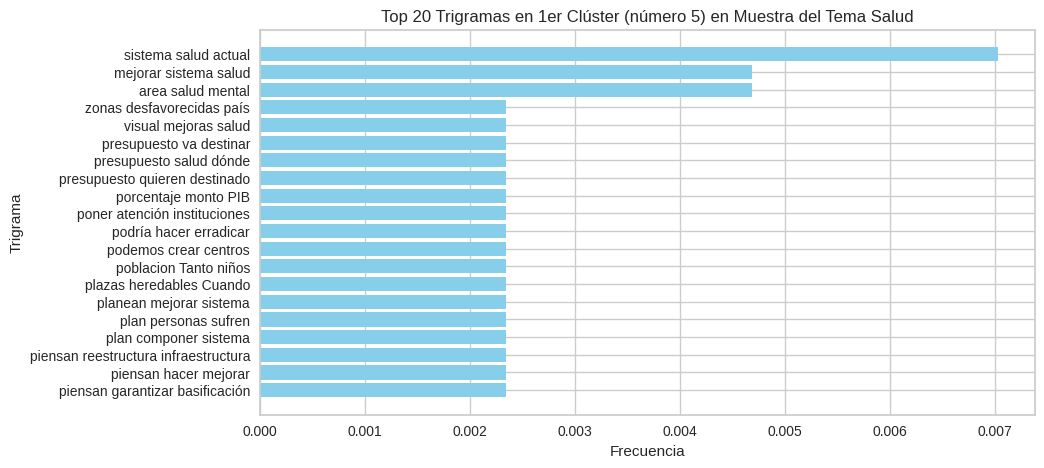

In [51]:
top_trigrams_cluster_1 = trigrama_cluster_1.head(20)

# Crear un gráfico de barras horizontal
plt.figure(figsize=(10, 5))
plt.barh(top_trigrams_cluster_1['source'] + ' ' + top_trigrams_cluster_1['middle'] + ' ' + top_trigrams_cluster_1['target'], top_trigrams_cluster_1['weight'], color='skyblue')
plt.xlabel('Frecuencia')
plt.ylabel('Trigrama')
plt.title(f'Top 20 Trigramas en 1er Clúster (número {cluster_1}) en Muestra del Tema {tema_muestra}')
plt.gca().invert_yaxis()
plt.show()

#### **Análisis semántico de 2ndo cluster** por cantidad de preguntas:

**Calcular términos más frecuentes por método TF-IDF para 2ndo clúster:**

In [52]:
# Indicar número de clúster y cantidad de términos a enlistar con mayor puntuación tras el análisis TF-IDF
cluster_tfid_2 = cluster_2
n_terminos = 20

# tfidf_por_cluster_region = funcion_tfidf(dfClusterizado, n=3, agrupar_por_region=True, n_cluster=cluster_tfid)
tfidf_por_cluster_2 = funcion_tfidf_cluster(dfClusterizado, n=n_terminos, agrupar_por_region=False, n_cluster=cluster_tfid_2)

In [53]:
cluster_2

3

In [54]:
# Enlistar términos con mayor frecuencia en clúster calculados por análisis TF-IDF
tfidf_por_cluster_2

{3: [('salud', 0.06399090037668077),
  ('medicamentos', 0.055076485287997204),
  ('hospitales', 0.042645119435690576),
  ('cómo', 0.03657563583981729),
  ('imss', 0.034710129556976506),
  ('como', 0.03378148143798729),
  ('medicinas', 0.03256466124481961),
  ('atención', 0.03132162558578646),
  ('falta', 0.0310267745280724),
  ('que', 0.02946779211856106),
  ('desabasto', 0.02680609407391692),
  ('médicos', 0.026732585150619197),
  ('mejor', 0.02441883793369469),
  ('mejorar', 0.024333624125028763),
  ('servicio', 0.024000041694563132),
  ('hacer', 0.02204168806226705),
  ('país', 0.021362710345088853),
  ('issste', 0.020889388452006816),
  ('servicios', 0.020408849318987052),
  ('en', 0.01962643700598658)]}

In [55]:
# Enlistar términos con mayor frecuencia en clúster calculados por análisis TF-IDF
tfidf_por_cluster_2 = tfidf_por_cluster_2[cluster_2]
tfidf_por_cluster_2

[('salud', 0.06399090037668077),
 ('medicamentos', 0.055076485287997204),
 ('hospitales', 0.042645119435690576),
 ('cómo', 0.03657563583981729),
 ('imss', 0.034710129556976506),
 ('como', 0.03378148143798729),
 ('medicinas', 0.03256466124481961),
 ('atención', 0.03132162558578646),
 ('falta', 0.0310267745280724),
 ('que', 0.02946779211856106),
 ('desabasto', 0.02680609407391692),
 ('médicos', 0.026732585150619197),
 ('mejor', 0.02441883793369469),
 ('mejorar', 0.024333624125028763),
 ('servicio', 0.024000041694563132),
 ('hacer', 0.02204168806226705),
 ('país', 0.021362710345088853),
 ('issste', 0.020889388452006816),
 ('servicios', 0.020408849318987052),
 ('en', 0.01962643700598658)]

In [56]:
df_tfidf_cluster_2 = pd.DataFrame(tfidf_por_cluster_2, columns=["términos","coeficientes"])

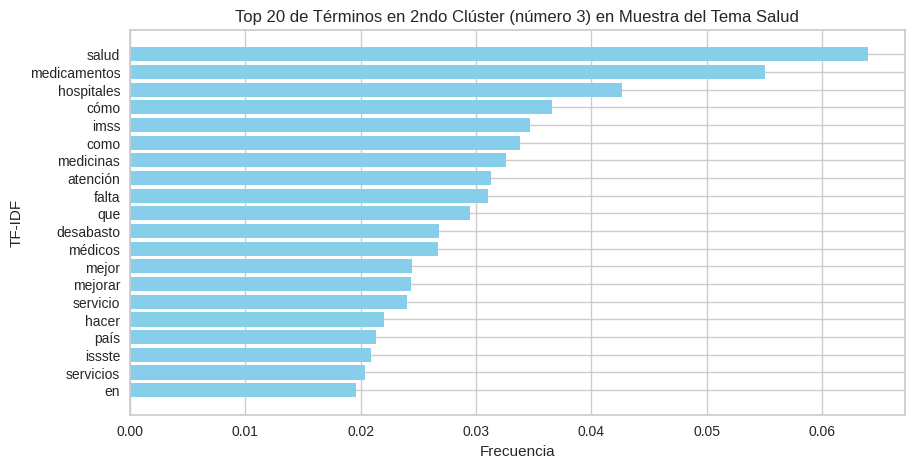

In [57]:
top_tfidf_cluster_2 = df_tfidf_cluster_2.head(20)

# Crear un gráfico de barras horizontal
plt.figure(figsize=(10, 5))
plt.barh(top_tfidf_cluster_2['términos'], top_tfidf_cluster_2['coeficientes'], color='skyblue')
plt.xlabel('Frecuencia')
plt.ylabel('TF-IDF')
plt.title(f'Top 20 de Términos en 2ndo Clúster (número {cluster_2}) en Muestra del Tema {tema_muestra}')
plt.gca().invert_yaxis()
plt.show()

**Calcular bigrama para 2ndo clúster:**

In [58]:
# Indicar número de clúster con mayor cantidad de preguntas
n_cluster_2 = cluster_2
bigrama_cluster_2 = calculate_bigrams(dfClusterizado, n_cluster_2)
bigrama_cluster_2

,source,target,weight
0,falta,medicamentos,0.004246
2,servicios,salud,0.004246
1,sector,salud,0.004246
3,centros,salud,0.003185
4,hospitales,clínicas,0.003185
...,...,...,...
320,eficacia,servicios,0.001062
321,eficientes,tiempo,0.001062
322,ejemplo,lentitud,0.001062
323,emergencias,básicas,0.001062


**Visualizar bigrama de 2ndo cluster** con mayor cantidad de preguntas:

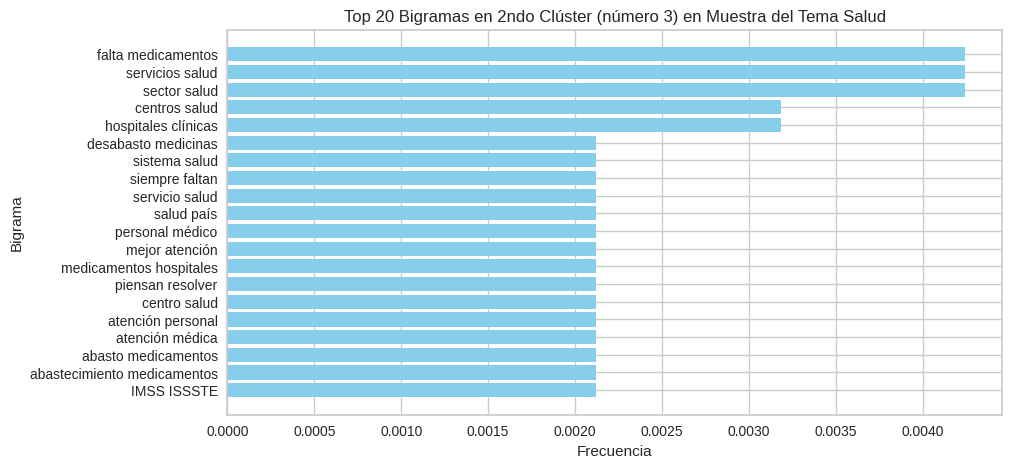

In [59]:
top_bigrams_cluster_2 = bigrama_cluster_2.head(20)

# Crear un gráfico de barras horizontal
plt.figure(figsize=(10, 5))
plt.barh(top_bigrams_cluster_2['source'] + ' ' + top_bigrams_cluster_2['target'], top_bigrams_cluster_2['weight'], color='skyblue')
plt.xlabel('Frecuencia')
plt.ylabel('Bigrama')
plt.title(f'Top 20 Bigramas en 2ndo Clúster (número {cluster_2}) en Muestra del Tema {tema_muestra}')
plt.gca().invert_yaxis()
plt.show()

**Calcular trigrama para 2ndo clúster:**

In [60]:
n_cluster_2 = cluster_2
trigrama_cluster_2 = calculate_trigrams(dfClusterizado, n_cluster_2)
trigrama_cluster_2

,source,middle,target,weight
0,100,cuanto,médicos,0.000982
682,médicos,mejor,trató,0.000982
669,médicas,Imss,bienestar,0.000982
670,médicas,existen,siempre,0.000982
671,médico,calidad,instancias,0.000982
...,...,...,...,...
343,deficiencias,ejemplo,lentitud,0.000982
344,deficiencias,instalaciones,atención,0.000982
345,demaciado,usted,propondria,0.000982
346,demanda,actual,potencial,0.000982


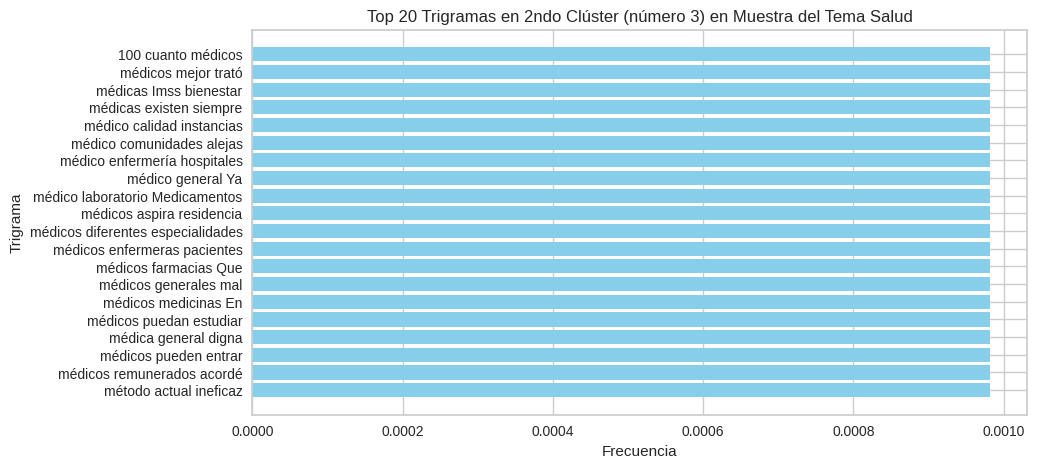

In [61]:
top_trigrams_cluster_2 = trigrama_cluster_2.head(20)

# Crear un gráfico de barras horizontal
plt.figure(figsize=(10, 5))
plt.barh(top_trigrams_cluster_2['source'] + ' ' + top_trigrams_cluster_2['middle'] + ' ' + top_trigrams_cluster_2['target'], top_trigrams_cluster_2['weight'], color='skyblue')
plt.xlabel('Frecuencia')
plt.ylabel('Trigrama')
plt.title(f'Top 20 Trigramas en 2ndo Clúster (número {cluster_2}) en Muestra del Tema {tema_muestra}')
plt.gca().invert_yaxis()
plt.show()

#### **Análisis semántico de 3er cluster** por cantidad de preguntas:

**Calcular términos más frecuentes por método TF-IDF para 3er clúster:**

In [62]:
# Indicar número de clúster y cantidad de términos a enlistar con mayor puntuación tras el análisis TF-IDF
cluster_tfid_3 = cluster_3
n_terminos = 20

# tfidf_por_cluster_region = funcion_tfidf(dfClusterizado, n=3, agrupar_por_region=True, n_cluster=cluster_tfid)
tfidf_por_cluster_3 = funcion_tfidf_cluster(dfClusterizado, n=n_terminos, agrupar_por_region=False, n_cluster=cluster_tfid_3)

In [63]:
# Enlistar términos con mayor frecuencia en clúster calculados por análisis TF-IDF
tfidf_por_cluster_3

{6: [('salud', 0.07928509672679102),
  ('sistema', 0.05446692878049612),
  ('méxico', 0.03643843498618106),
  ('mexicanos', 0.03309642707549963),
  ('hospitales', 0.029949607579681677),
  ('van', 0.028275861286475336),
  ('atención', 0.02802613855339812),
  ('plan', 0.02709251538529888),
  ('cómo', 0.0245010882629275),
  ('servicio', 0.023684385829964908),
  ('seguro', 0.023207614424156028),
  ('popular', 0.02098616252068699),
  ('años', 0.02065890707475379),
  ('población', 0.02050378876797713),
  ('el', 0.019905438229793695),
  ('medicamentos', 0.019876805098879555),
  ('mexicana', 0.019344298619733892),
  ('imss', 0.019308148983100647),
  ('que', 0.019182046566660213),
  ('mejor', 0.018589993445162774)]}

In [64]:
# Enlistar términos con mayor frecuencia en clúster calculados por análisis TF-IDF
tfidf_por_cluster_3 = tfidf_por_cluster_3[cluster_3]
tfidf_por_cluster_3

[('salud', 0.07928509672679102),
 ('sistema', 0.05446692878049612),
 ('méxico', 0.03643843498618106),
 ('mexicanos', 0.03309642707549963),
 ('hospitales', 0.029949607579681677),
 ('van', 0.028275861286475336),
 ('atención', 0.02802613855339812),
 ('plan', 0.02709251538529888),
 ('cómo', 0.0245010882629275),
 ('servicio', 0.023684385829964908),
 ('seguro', 0.023207614424156028),
 ('popular', 0.02098616252068699),
 ('años', 0.02065890707475379),
 ('población', 0.02050378876797713),
 ('el', 0.019905438229793695),
 ('medicamentos', 0.019876805098879555),
 ('mexicana', 0.019344298619733892),
 ('imss', 0.019308148983100647),
 ('que', 0.019182046566660213),
 ('mejor', 0.018589993445162774)]

In [65]:
df_tfidf_cluster_3 = pd.DataFrame(tfidf_por_cluster_3, columns=["términos","coeficientes"])

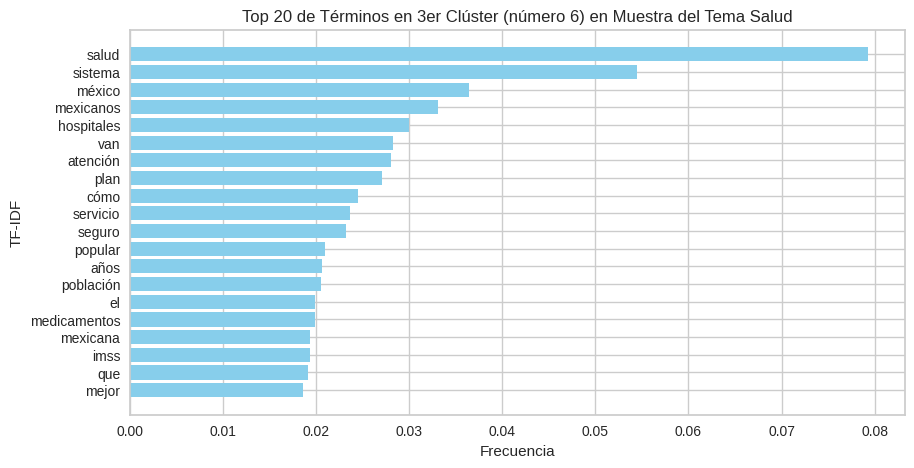

In [66]:
top_tfidf_cluster_3 = df_tfidf_cluster_3.head(20)

# Crear un gráfico de barras horizontal
plt.figure(figsize=(10, 5))
plt.barh(top_tfidf_cluster_3['términos'], top_tfidf_cluster_3['coeficientes'], color='skyblue')
plt.xlabel('Frecuencia')
plt.ylabel('TF-IDF')
plt.title(f'Top 20 de Términos en 3er Clúster (número {cluster_3}) en Muestra del Tema {tema_muestra}')
plt.gca().invert_yaxis()
plt.show()

**Calcular bigrama para 3er clúster:**

In [67]:
# Indicar número de clúster con mayor cantidad de preguntas
n_cluster_3 = cluster_3
bigrama_cluster_3 = calculate_bigrams(dfClusterizado, n_cluster_3)
bigrama_cluster_3

,source,target,weight
0,sistema,salud,0.018767
1,seguro,popular,0.004468
2,salud,mexicanos,0.003575
4,van,hacer,0.003575
3,salud,población,0.003575
...,...,...,...
375,cómo,logrará,0.000894
376,cómo,manejó,0.000894
377,cómo,piensa,0.000894
378,cómo,planea,0.000894


**Visualizar bigrama de 3er cluster** con mayor cantidad de preguntas:

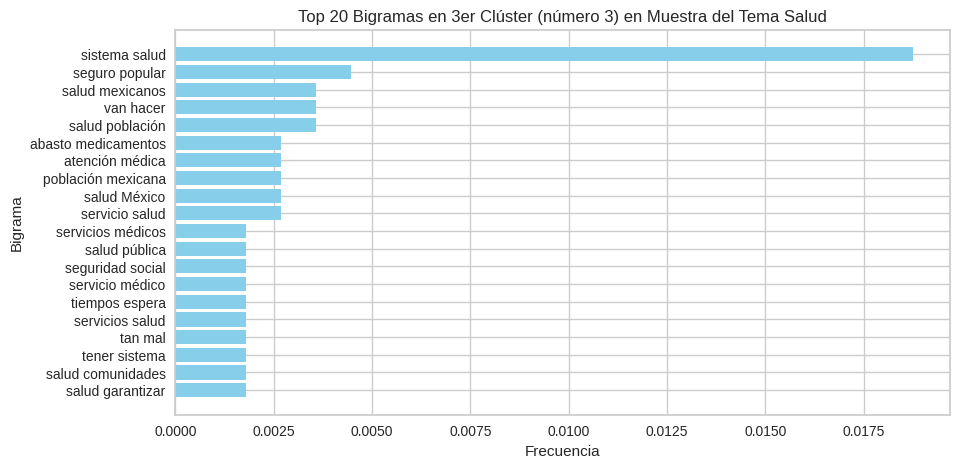

In [68]:
top_bigrams_cluster_3 = bigrama_cluster_3.head(20)

# Crear un gráfico de barras horizontal
plt.figure(figsize=(10, 5))
plt.barh(top_bigrams_cluster_3['source'] + ' ' + top_bigrams_cluster_3['target'], top_bigrams_cluster_3['weight'], color='skyblue')
plt.xlabel('Frecuencia')
plt.ylabel('Bigrama')
plt.title(f'Top 20 Bigramas en 3er Clúster (número {cluster_2}) en Muestra del Tema {tema_muestra}')
plt.gca().invert_yaxis()
plt.show()

**Calcular trigrama para 3er clúster:**

In [69]:
n_cluster_3= cluster_3
trigrama_cluster_3 = calculate_trigrams(dfClusterizado, n_cluster_3)
trigrama_cluster_3

,source,middle,target,weight
0,El,sistema,salud,0.001668
2,garantizar,salud,población,0.001668
3,jornada,laboral,40,0.001668
4,salud,población,mexicana,0.001668
5,tener,sistema,salud,0.001668
...,...,...,...,...
399,continúa,contagios,Soy,0.000834
398,contemplar,necesidades,población,0.000834
397,contempla,devolverle,México,0.000834
396,contar,agua,Piensan,0.000834


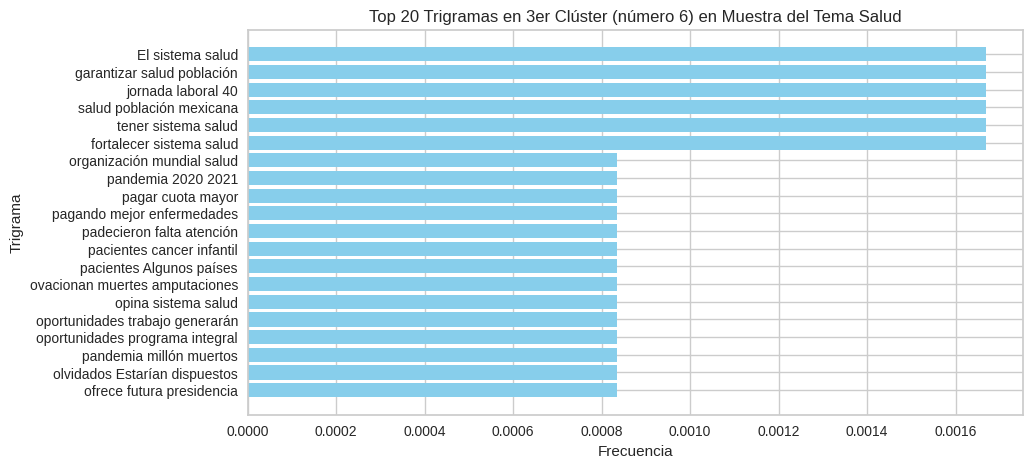

In [70]:
top_trigrams_cluster_3 = trigrama_cluster_3.head(20)

# Crear un gráfico de barras horizontal
plt.figure(figsize=(10, 5))
plt.barh(top_trigrams_cluster_3['source'] + ' ' + top_trigrams_cluster_3['middle'] + ' ' + top_trigrams_cluster_3['target'], top_trigrams_cluster_3['weight'], color='skyblue')
plt.xlabel('Frecuencia')
plt.ylabel('Trigrama')
plt.title(f'Top 20 Trigramas en 3er Clúster (número {cluster_3}) en Muestra del Tema {tema_muestra}')
plt.gca().invert_yaxis()
plt.show()

### **Búsqueda semántica por clústers para selección de preguntas por frecuencia**

In [71]:
def dotProduct(embedding1,embedding2):
  result = 0
  for e1, e2 in zip(embedding1, embedding2):
    result += e1*e2
  return result

# Definir función para generar consultas basadas en búsqueda semántica, con definición de tarea (task) y términos de consulta (dados por TF-IDF/bigramas), con modelo multilingual-e5-large-instruct
def searchIntFloat(model, task, query, df, colText, colEmbedding, cluster=None):
  dfW = df.copy()
  if cluster is not None:
    dfW = dfW[dfW["cluster"] == cluster]

  def get_detailed_instruct(task_description: str, query: str) -> str:
    return f'Instruct: {task_description}\nQuery: {query}'

  task = task
  queries = [
    get_detailed_instruct(task, query)
  ]

  res = {
    "text": dfW[colText].tolist(),
    "embeddings": dfW["Embedding"].tolist(),
    "scores": []
  }

  queryEmbeddings = model.encode(queries, convert_to_tensor=True, normalize_embeddings=True).tolist()[0]
  listOfTweetsAndSimilarity = []
  for index, row in dfW.iterrows():
      embeddingRow = row[colEmbedding]
      similarity = dotProduct(queryEmbeddings, embeddingRow)
      listOfTweetsAndSimilarity.append([row['id'], row[colText], similarity])
  listOfTweetsAndSimilarity = sorted(listOfTweetsAndSimilarity, key=operator.itemgetter(2), reverse=True)
  listIds = [x[0] for x in listOfTweetsAndSimilarity]
  listOfTweets = [x[1] for x in listOfTweetsAndSimilarity]
  listOfSim = [x[2] for x in listOfTweetsAndSimilarity]
  dfRet = {
      "id": listIds,
      "texto": listOfTweets,
      "Similitud": listOfSim
  }
  dfRet = pd.DataFrame.from_dict(dfRet)
  print(f"Búsqueda en {colText} de: {query}")
  for i, row in dfRet.iterrows():
    print(f"id: {row['id']}")
    print(f"Similitud: {row['Similitud']} - {i} - {row['texto']}")
    print("--------")
    if i > 300:
      break

Definir parámetros y ejecutar **consulta por búsqueda semántica de 1er clúster:**

In [ ]:
# Parámetros para ejecutar consulta por búsqueda semántica de 1er clúster:
task_1 = 'Preguntas sobre el tema de Salud'

# Términos de consulta definidos tras el análisis cualitativo orientado la cotejación de palabras más frecuentes (método TF-IDF) y relaciones entre palabras con mayor peso (bigramas y trigramas)
query_1 = "mejorar el sistema de salud pública actual y atención a la salud mental"

columnaTexto = "clean_text"
columnaEmbeddings = "Embedding"
cluster = cluster_1

# Ejecutar consulta por búsqueda semántica:
searchIntFloat(embedder, task_1, query_1, dfClusterizado, columnaTexto, columnaEmbeddings, cluster)

In [ ]:
# Pregunta elegida de 1er clúster por ID
dfClusterizado[dfClusterizado["id"]== 114984]

Definir parámetros y ejecutar **consulta por búsqueda semántica de 2ndo clúster:**

In [ ]:
# Parámetros para ejecutar consulta por búsqueda semántica de 2ndo clúster:
task_2 = 'Preguntas sobre el tema de Salud'

# Términos de consulta definidos tras el análisis cualitativo orientado la cotejación de palabras más frecuentes (método TF-IDF) y relaciones entre palabras con mayor peso (bigramas y trigramas)

query_2 = "falta de medicamentos en hospitales, clínicas y en el sector salud"

columnaTexto = "clean_text"
columnaEmbeddings = "Embedding"
cluster = cluster_2

# Ejecutar consulta por búsqueda semántica:
searchIntFloat(embedder, task_2, query_2, dfClusterizado, columnaTexto, columnaEmbeddings, cluster)

In [ ]:
# Pregunta elegida de 2ndo clúster por ID
dfClusterizado[dfClusterizado["id"]== 27801]

Definir parámetros y ejecutar **consulta por búsqueda semántica de 3er clúster:**

In [ ]:
# Parámetros para ejecutar consulta por búsqueda semántica de 3er clúster:
task_3 = 'Preguntas sobre el tema de Salud'

# Términos de consulta definidos tras el análisis cualitativo orientado la cotejación de palabras más frecuentes (método TF-IDF) y relaciones entre palabras con mayor peso (bigramas y trigramas)
query_3 = "fortalecer el sistema de salud después del Seguro Popular"

columnaTexto = "clean_text"
columnaEmbeddings = "Embedding"
cluster = cluster_3

# Ejecutar consulta por búsqueda semántica:
searchIntFloat(embedder, task_3, query_3, dfClusterizado, columnaTexto, columnaEmbeddings, cluster)

In [ ]:
# Pregunta elegida de 3er clúster por ID
dfClusterizado[dfClusterizado["id"]== 75681]

**Enlistar 3 IDs de preguntas seleccionadas por frecuencia del tema** tras su exploración y selección con búsqueda semántica (con términos identificados en TF-IF y bigramas):

In [78]:
#Inicializar DataFrame Preguntas Seleccionadas
dfPregSeleccionadas = pd.DataFrame(columns=dfClusterizado.columns)

In [79]:
# Definir función que recibe una lista de los 3 IDs de preguntas seleccionadas por frecuencia para crear DataFrame (df_seleccion_frecuencia) con esas 3 preguntas y sus propiedades correspondientes
def seleccionar_pregunta_frecuencias(dfClusters, dfSelectedQuestions, indice_pregunta):
    # Convertir el índice a entero si es posible
    try:
        indice_pregunta = int(indice_pregunta)
    except ValueError:
        # Manejar el caso en el que el índice no se pueda convertir a entero
        print("El índice proporcionado no es un entero.")
        return dfClusters, dfSelectedQuestions

    # Verificar si el índice dado está dentro del rango del DataFrame
    if indice_pregunta in dfClusters["id"].values:
        # Obtener la fila correspondiente al índice dado
        df_filtrado = dfClusters[dfClusters["id"] == indice_pregunta]
        pregunta_seleccionada = df_filtrado.iloc[0].copy()

        # Eliminar de DataFrame global de la muestra la preguntas seleccionadas por frecuencia, indicada por ID, para evitar su aparición en la siguiente etapa de selección aleatoria
        dfClusters.drop(index=df_filtrado.index[0], inplace=True)

        # Obtener el índice para la nueva fila en el DataFrame de preguntas seleccionadas
        nuevo_indice = len(dfSelectedQuestions)

        # Agregar la fila al DataFrame de preguntas seleccionadas utilizando loc
        dfSelectedQuestions.loc[nuevo_indice] = pregunta_seleccionada

    return dfClusters, dfSelectedQuestions


In [80]:
dfClusterizado, dfPregSeleccionadas= seleccionar_pregunta_frecuencias(dfClusterizado, dfPregSeleccionadas, '114984')

In [81]:
dfClusterizado, dfPregSeleccionadas= seleccionar_pregunta_frecuencias(dfClusterizado, dfPregSeleccionadas, '27801')

In [82]:
dfClusterizado, dfPregSeleccionadas= seleccionar_pregunta_frecuencias(dfClusterizado, dfPregSeleccionadas, '75681')

In [ ]:
dfPregSeleccionadas

In [ ]:
#Verificar eliminacion por id
id_por_verficar = '75681'
dfClusterizado[dfClusterizado['id'] == id_por_verficar]

In [85]:
# Exportar archivo de datos (en formato CSV) con preguntas descartadas tras la revisión manual de la selección aleatoria y su razonamiento
dfPregSeleccionadas.to_csv(f"{nombreArchivo}PreguntasSeleccionadasFrecuencia.csv")

In [86]:
# Exportar archivo de datos (en formato CSV) con preguntas descartadas tras la revisión manual de la selección aleatoria y su razonamiento
dfClusterizado.to_csv(f"{nombreArchivo}MuestraSinPreguntasFrecuencia.csv")

## **5. Selección aleatoria de preguntas por tema y región**

Definir función para generar y visualizar tabla de datos con **selección aleatoria de 5 preguntas por tema y región.**

In [87]:
# Semilla para fijar la generación aleatoria
seed_sample = 2024

# Agrupar por región
grouped = dfClusterizado.groupby('region')

# Seleccionar aleatoriamente 5 preguntas por tema en cada región
sampled_questions = []
for name, group in grouped:
    # Agrupar por tema dentro de cada región
    grouped_by_tema = group.groupby('tema')
    # Seleccionar aleatoriamente 5 preguntas de cada tema
    sampled_questions_by_tema = grouped_by_tema.apply(lambda x: x.sample(n=5, replace=False, random_state=seed_sample))
    sampled_questions.append(sampled_questions_by_tema)

# Concatenar los DataFrames de las preguntas seleccionadas
sampled_df = pd.concat(sampled_questions, ignore_index=True)

/tmp/ipykernel_29472/1979578203.py:13: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/tmp/ipykernel_29472/1979578203.py:13: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/tmp/ipykernel_29472/1979578203.py:13: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Ei

In [ ]:
# Previsualizar tabla con 15 preguntas seleccionadas aleatoriamente
sampled_df

In [ ]:
# Imprimir texto completo de preguntas seleccionadas
print(sampled_df['clean_text'].to_markdown())


## **6. Exportar archivo de datos consolidado con selección inicial de preguntas por frecuencia y aleatoriedad**

In [90]:
# Unir tablas de preguntas seleccionadas por frecuencia y por aleatoriedad

# Añadir una nueva columna a cada DataFrame para indicar su categoría de origen
dfPregSeleccionadas['Criterio'] = 'Frecuencia'
sampled_df['Criterio'] = 'Aleatoriedad'


# Ahora concatena los DataFrames ya modificados
dfPreguntasSeleccionadasTema = pd.concat([dfPregSeleccionadas, sampled_df], axis=0)

dfPreguntasSeleccionadasTema.reset_index(drop=True, inplace=True)

In [ ]:
dfPreguntasSeleccionadasTema

In [92]:
dfPreguntasSeleccionadasTema.shape

(18, 17)

In [93]:
# Exportar archivo de datos (en formato CSV) con preguntas descartadas tras la revisión manual de la selección aleatoria y su razonamiento
dfPreguntasSeleccionadasTema.to_csv(f"{nombreArchivo}_PrimeraSeleccionPreguntas_FrecuenciaAleatoriedad.csv")

## 7. Referencias:

* Bird, Steven, Edward Loper & Ewan Klein (2009). Natural Language Processing with Python.  O'Reilly Media Inc.
* Instituto Nacional Electoral. (2024). Acuerdo INE/CG95/2024. Acuerdo del Consejo General del Instituto Nacional Electoral por el que se define la metodología, así como la instancia que seleccionará las preguntas provenientes de redes sociales relativas al Formato Tipo A que se utilizará en el Primer Debate Presidencial en el Proceso Electoral Federal 2023-2024. Repositorio Documental INE. https://repositoriodocumental.ine.mx/xmlui/bitstream/handle/123456789/164296/CGex202402-08-ap-3.pdf
* Instituto Nacional Electoral. (2024). Anexo I. Metodología Selección de Preguntas para Debate Formato A. Repositorio Documental INE. https://repositoriodocumental.ine.mx/xmlui/bitstream/handle/123456789/164296/CGex202402-08-ap-3-a1.pdf
* McInnes, L., Healy, J., & Melville, J. (2018). Umap: Uniform manifold approximation and projection for dimension reduction. arXiv preprint arXiv:1802.03426. https://arxiv.org/abs/1802.03426
* Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M., Duchesnay, E., & others. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12, 2825–2830.
* Reimers, N., & Gurevych, I. (2019). Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks (arXiv:1908.10084). arXiv. http://arxiv.org/abs/1908.10084
* Rousseeuw, P. (1987). Silhouettes: a Graphical Aid to the Interpretation and Validation of Cluster Analysis. Computational and Applied Mathematics. 20: 53–65. doi:10.1016/0377-0427(87)90125-7.
* Spärck-Jones, K. (1972). A statistical interpretation of term specificity and its application in retrieval. Journal of Documentation, 28(1), 11-21. https://www.staff.city.ac.uk/~sbrp622/idfpapers/ksj_orig.pdf
* Thorndike, R. (1953). Who Belongs in the Family?. Psychometrika. 18 (4): 267–276. doi:10.1007/BF02289263. S2CID 120467216.
* Wang, L., Yang, N., Huang, X., Yang, L., Majumder, R., & Wei, F. (2024). Multilingual E5 Text Embeddings: A Technical Report. arXiv preprint arXiv:2402.05672. Recuperado de https://arxiv.org/abs/2402.05672